# Introduction (Himmelblau's function)



Let's use ``blop`` to minimize Himmelblau's function, which has four global minima:

In [1]:
from blop.utils import prepare_re_env

%run -i $prepare_re_env.__file__ --db-type=temp

Text(0, 0.5, 'x2')

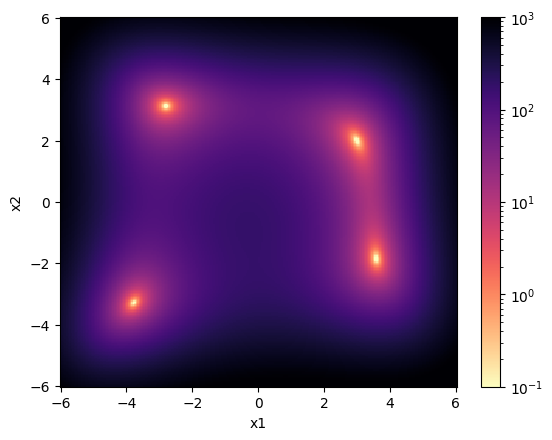

In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from blop.utils import functions

x1 = x2 = np.linspace(-6, 6, 256)
X1, X2 = np.meshgrid(x1, x2)

F = functions.himmelblau(X1, X2)

plt.pcolormesh(x1, x2, F, norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e3), cmap="magma_r")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")

There are several things that our agent will need. The first ingredient is some degrees of freedom (these are always `ophyd` devices) which the agent will move around to different inputs within each DOF's bounds (the second ingredient). We define these here:

In [3]:
from blop import DOF

dofs = [
    DOF(name="x1", search_bounds=(-6, 6)),
    DOF(name="x2", search_bounds=(-6, 6)),
]

We also need to give the agent something to do. We want our agent to look in the feedback for a variable called 'himmelblau', and try to minimize it.

In [4]:
from blop import Objective

objectives = [Objective(name="himmelblau", description="Himmeblau's function", target="min")]

In our digestion function, we define our objective as a deterministic function of the inputs:

In [5]:
def digestion(db, uid):
    products = db[uid].table()

    for index, entry in products.iterrows():
        products.loc[index, "himmelblau"] = functions.himmelblau(entry.x1, entry.x2)

    return products

We then combine these ingredients into an agent, giving it an instance of ``databroker`` so that it can see the output of the plans it runs.

In [6]:
from blop import Agent

agent = Agent(
    dofs=dofs,
    objectives=objectives,
    digestion=digestion,
    db=db,
)

Without any data, we can't make any inferences about what the function looks like, and so we can't use any non-trivial acquisition functions. Let's start by quasi-randomly sampling the parameter space, and plotting our model of the function:

running iteration 1 / 1


Transient Scan ID: 1     Time: 2024-02-03 16:53:30
Persistent Unique Scan ID: '79d0d4b5-aac0-4e01-9ee9-e4b37d9f1472'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 16:53:30.4 |      1.159 |      0.228 |
|         2 | 16:53:30.4 |      1.114 |     -0.411 |
|         3 | 16:53:30.4 |     -0.796 |     -1.251 |
|         4 | 16:53:30.4 |     -1.477 |      1.065 |
|         5 | 16:53:30.4 |     -2.477 |      1.688 |
|         6 | 16:53:30.4 |     -4.006 |      2.704 |
|         7 | 16:53:30.4 |     -4.850 |      4.486 |
|         8 | 16:53:30.4 |     -3.569 |      5.110 |
|         9 | 16:53:30.4 |     -2.135 |      5.281 |
|        10 | 16:53:30.4 |     -0.320 |      3.099 |
|        11 | 16:53:30.4 |      0.090 |      3.772 |
|        12 | 16:53:30.4 |      2.002 |      4.629 |
|        13 | 16:53:30.4 |      3.520 | 

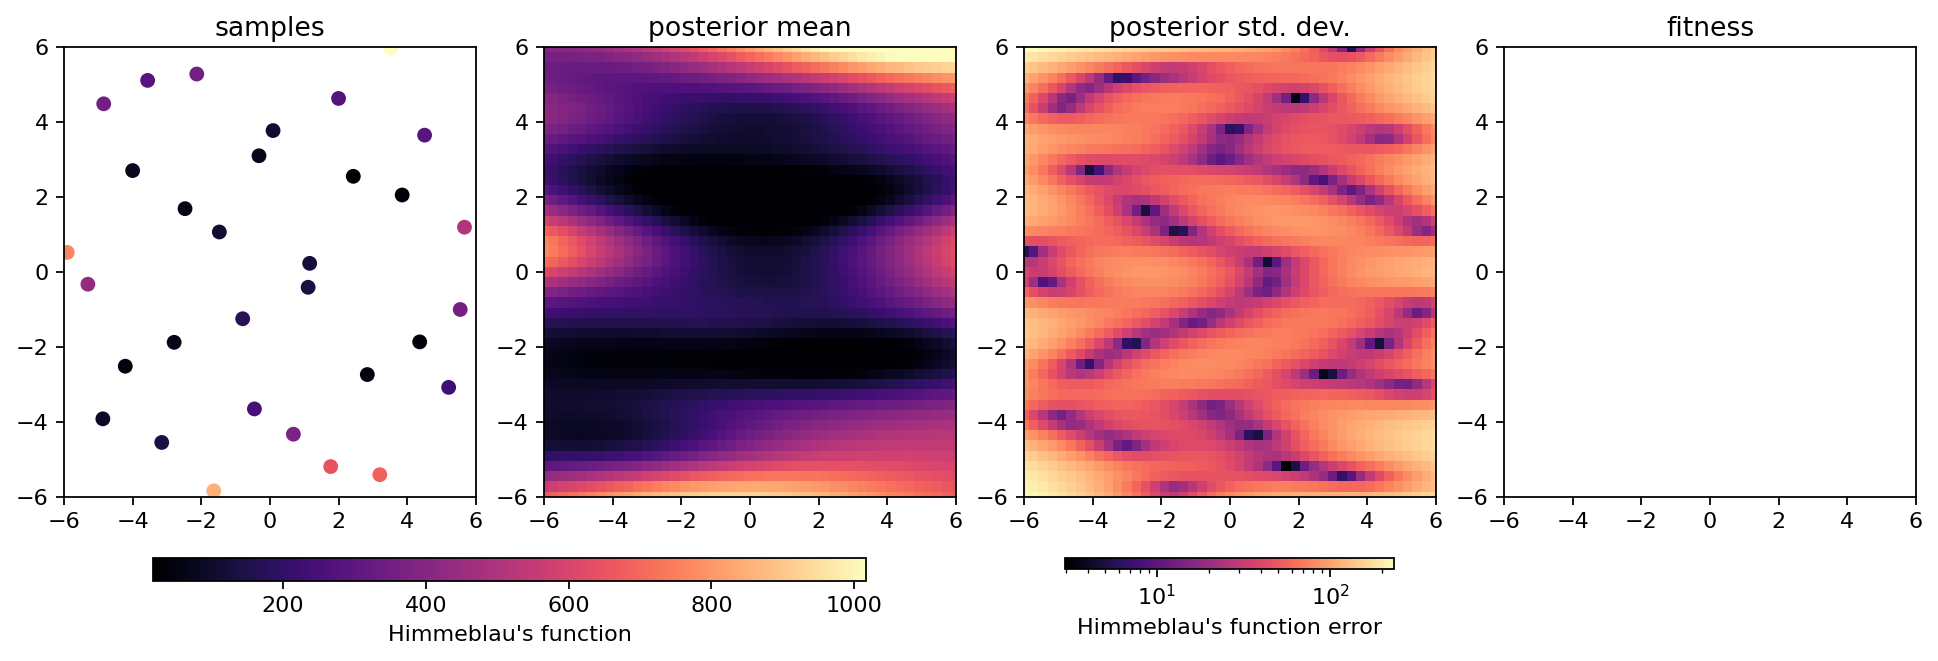

In [7]:
RE(agent.learn("quasi-random", n=32))
agent.plot_objectives()

To decide which points to sample, the agent needs an acquisition function. The available acquisition function are here:

In [8]:
agent.all_acq_funcs

EXPECTED IMPROVEMENT (identifiers: ['ei', 'expected_improvement'])
-> The expected value of max(f(x) - \nu, 0), where \nu is the current maximum.

MONTE CARLO EXPECTED IMPROVEMENT (identifiers: ['qei', 'monte_carlo_expected_improvement'])
-> The expected value of max(f(x) - \nu, 0), where \nu is the current maximum.

EXPECTED MEAN (identifiers: ['em', 'expected_mean'])
-> The expected value at each input.

MONTE CARLO EXPECTED MEAN (identifiers: ['qem', 'monte_carlo_expected_mean'])
-> The expected value at each input.

LOWER BOUND MAX VALUE ENTROPY (identifiers: ['lbmve', 'lbmes', 'gibbon', 'lower_bound_max_value_entropy'])
-> Max entropy search, basically

NOISY EXPECTED HYPERVOLUME IMPROVEMENT (identifiers: ['nehvi', 'noisy_expected_hypervolume_improvement'])
-> It's like a big box. How big is the box?

PROBABILITY OF IMPROVEMENT (identifiers: ['pi', 'probability_of_improvement'])
-> The probability that this input improves on the current maximum.

MONTE CARLO PROBABILITY OF IMPROVE

Now we can start to learn intelligently. Using the shorthand acquisition functions shown above, we can see the output of a few different ones:

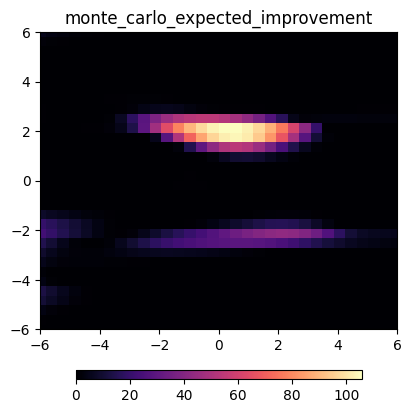

In [9]:
agent.plot_acquisition(acq_func="qei")

To decide where to go, the agent will find the inputs that maximize a given acquisition function:

In [10]:
agent.ask("qei", n=1)

{'points': array([[0.48789213, 1.94829756]]),
 'acq_func': 'monte_carlo_expected_improvement',
 'acq_func_kwargs': {},
 'acq_func_obj': array([113.1732276]),
 'duration_ms': 356.0719050000216,
 'sequential': True,
 'upsample': 1,
 'read_only_values': array([], shape=(1, 0), dtype=float64),
 'posterior': <botorch.posteriors.gpytorch.GPyTorchPosterior at 0x7f6490274ee0>}

We can also ask the agent for multiple points to sample and it will jointly maximize the acquisition function over all sets of inputs, and find the most efficient route between them:

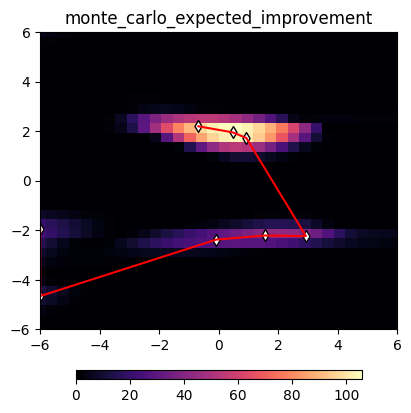

In [11]:
res = agent.ask("qei", n=8, route=True)
agent.plot_acquisition(acq_func="qei")
plt.scatter(*res["points"].T, marker="d", facecolor="w", edgecolor="k")
plt.plot(
    *res["points"].T,
    color="r",
)

All of this is automated inside the ``learn`` method, which will find a point (or points) to sample, sample them, and retrain the model and its hyperparameters with the new data. To do 4 learning iterations of 8 points each, we can run

In [12]:
RE(agent.learn("qei", n=4, iterations=8))

running iteration 1 / 8




Transient Scan ID: 2     Time: 2024-02-03 16:53:37
Persistent Unique Scan ID: '5194a73e-1acd-462c-8ffd-d1d6948f2597'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 16:53:37.5 |     -6.000 |     -1.948 |
|         2 | 16:53:37.5 |      1.569 |     -2.209 |
|         3 | 16:53:37.5 |      0.923 |      1.730 |
|         4 | 16:53:37.5 |      0.487 |      1.948 |
+-----------+------------+------------+------------+
generator list_scan ['5194a73e'] (scan num: 2)





running iteration 2 / 8




Transient Scan ID: 3     Time: 2024-02-03 16:53:39
Persistent Unique Scan ID: 'b12e6c66-b504-45cb-aabc-57a2a068832b'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 16:53:39.0 |     -2.772 |      3.127 |
|         2 | 16:53:39.0 |      3.208 |     -0.183 |
|         3 | 16:53:39.0 |      3.377 |     -1.532 |
|         4 | 16:53:39.0 |     -3.661 |     -3.343 |
+-----------+------------+------------+------------+
generator list_scan ['b12e6c66'] (scan num: 3)





running iteration 3 / 8




Transient Scan ID: 4     Time: 2024-02-03 16:53:40
Persistent Unique Scan ID: 'c8158162-9a95-409a-a9e0-0aa315913bee'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 16:53:40.6 |     -6.000 |     -6.000 |
|         2 | 16:53:40.6 |     -2.983 |      2.815 |
|         3 | 16:53:40.6 |      3.121 |      2.484 |
|         4 | 16:53:40.6 |      3.001 |      1.596 |
+-----------+------------+------------+------------+
generator list_scan ['c8158162'] (scan num: 4)





running iteration 4 / 8




Transient Scan ID: 5     Time: 2024-02-03 16:53:42
Persistent Unique Scan ID: 'a704990b-4a7b-4b67-a03b-ba1ca5598736'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 16:53:42.7 |      3.609 |     -2.081 |
|         2 | 16:53:42.7 |     -3.971 |     -3.561 |
|         3 | 16:53:42.7 |     -3.263 |     -0.138 |
|         4 | 16:53:42.7 |     -2.230 |      2.972 |
+-----------+------------+------------+------------+
generator list_scan ['a704990b'] (scan num: 5)





running iteration 5 / 8




Transient Scan ID: 6     Time: 2024-02-03 16:53:44
Persistent Unique Scan ID: '2f0e0a2f-a175-4723-923f-ac87bd49b30e'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 16:53:44.8 |     -3.081 |      3.241 |
|         2 | 16:53:44.8 |      3.006 |      2.022 |
|         3 | 16:53:44.8 |      3.242 |      0.962 |
|         4 | 16:53:44.8 |      3.647 |     -1.737 |
+-----------+------------+------------+------------+
generator list_scan ['2f0e0a2f'] (scan num: 6)





running iteration 6 / 8




Transient Scan ID: 7     Time: 2024-02-03 16:53:47
Persistent Unique Scan ID: '46be7f61-8c15-418a-9f02-36da774e2751'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 16:53:47.9 |      3.525 |     -1.874 |
|         2 | 16:53:47.9 |      3.587 |     -1.103 |
|         3 | 16:53:47.9 |      3.164 |      1.866 |
|         4 | 16:53:47.9 |      2.811 |      2.053 |
+-----------+------------+------------+------------+
generator list_scan ['46be7f61'] (scan num: 7)





running iteration 7 / 8




Transient Scan ID: 8     Time: 2024-02-03 16:53:50
Persistent Unique Scan ID: '030bd872-ccb2-426d-846f-29241a2ff571'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 16:53:50.1 |     -3.301 |     -3.115 |
|         2 | 16:53:50.1 |     -3.610 |     -2.982 |
|         3 | 16:53:50.1 |     -3.775 |     -3.180 |
|         4 | 16:53:50.1 |     -3.660 |     -3.529 |
+-----------+------------+------------+------------+
generator list_scan ['030bd872'] (scan num: 8)





running iteration 8 / 8




Transient Scan ID: 9     Time: 2024-02-03 16:53:51
Persistent Unique Scan ID: '341994fe-35db-4014-8817-3da225b6b6b2'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 16:53:51.4 |     -2.836 |      3.091 |
|         2 | 16:53:51.4 |     -2.733 |      3.254 |
|         3 | 16:53:51.4 |     -2.189 |      3.540 |
|         4 | 16:53:51.4 |      3.007 |      1.994 |
+-----------+------------+------------+------------+
generator list_scan ['341994fe'] (scan num: 9)





('5194a73e-1acd-462c-8ffd-d1d6948f2597',
 'b12e6c66-b504-45cb-aabc-57a2a068832b',
 'c8158162-9a95-409a-a9e0-0aa315913bee',
 'a704990b-4a7b-4b67-a03b-ba1ca5598736',
 '2f0e0a2f-a175-4723-923f-ac87bd49b30e',
 '46be7f61-8c15-418a-9f02-36da774e2751',
 '030bd872-ccb2-426d-846f-29241a2ff571',
 '341994fe-35db-4014-8817-3da225b6b6b2')

Our agent has found all the global minima of Himmelblau's function using Bayesian optimization, and we can ask it for the best point: 

x1                                    3.006947
x2                                    1.993587
himmelblau                            0.001596
time                       1706979231431943178
acq_func      monte_carlo_expected_improvement
Name: 63, dtype: object


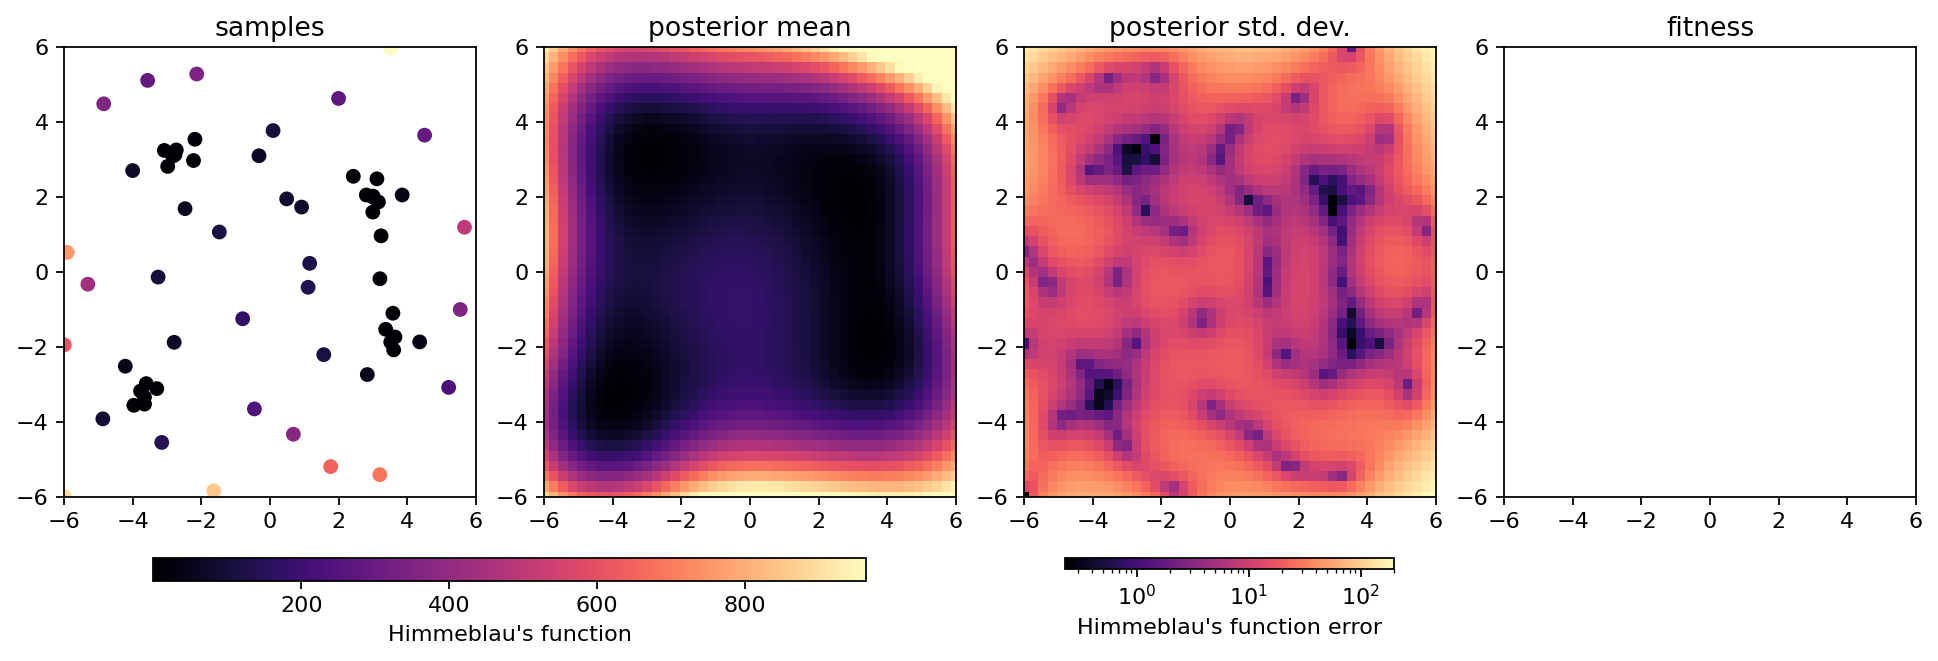

In [13]:
agent.plot_objectives()
print(agent.best)